In [1]:
import uproot
import numpy as np
import os
liczba = os.popen('cd dane/nowe; find -type f | wc -l').read()
liczba2 = int(liczba)

In [2]:
import glob
file_pattern = "dane/nowe/*.root"
files = glob.glob(file_pattern)

In [47]:
file1 = uproot.open("dane/700490.root")
file2 = uproot.open("dane/700492.root")
file3 = uproot.open("dane/700493.root")


In [46]:
branches1 = file1['nominal'].arrays(library="np")
branches2 = file2['nominal'].arrays(library="np")
branches3 = file3['nominal'].arrays(library="np")


In [3]:
branch_list = [uproot.open(files[i])['nominal'].arrays(library="np") for i in range (liczba2) ]

In [4]:
combined_data = {}

In [5]:
def delete_branches(branches):
    del branches['jet_isbtagged_DL1r_77']
    del branches['mc_kFactor']
    del branches['RunYear']
    del branches['mc_rawXSection']
    del branches['lep_ID_0']

In [6]:
for i in branch_list:
    delete_branches(i)
    

In [9]:
keys = list(branch_list[0])

In [10]:
'''
k = 0
l = 0
for key in keys:
    for i in range(len(branches3[key])):
        if (np.array_equal(branches3[key][i], branches4[key][i])):
            k += 1
        else:
            l += 1

print(k)
print(l)
'''

'\nk = 0\nl = 0\nfor key in keys:\n    for i in range(len(branches3[key])):\n        if (np.array_equal(branches3[key][i], branches4[key][i])):\n            k += 1\n        else:\n            l += 1\n\nprint(k)\nprint(l)\n'

In [11]:
def join_branchKey(arr):
    combo = arr
    if len(arr) > 1:
        combo = np.concatenate([arr[0], arr[1]])
        for i in range(len(arr)):
            combo = np.concatenate([combo, arr[i]])
    return combo

In [12]:
def join_branch(branch):
    for key in keys:
        if all(isinstance(item, np.ndarray) for item in branch[key]):
            branch[key] = join_branchKey(branch[key])
    return branch

In [13]:
for i in range(len(branch_list)):
    branch_list[i] = join_branch(branch_list[i])

In [15]:
for i in keys:
    combo = np.concatenate([branch_list[0][i], branch_list[1][i]])
    for k in branch_list:
        combo = np.concatenate([combo, k[i]])
    combined_data[i] = combo
    try:
        combined_data[i] = combined_data[i].astype(np.float32)
    except ValueError:
        print(i)

In [16]:
combined_data = join_branch(combined_data)

In [17]:
def minus_value_filter(keys, branch):
    try:
        for key in keys:
            min = np.min(branch[key])
            max = np.max(branch[key])
            distance = abs(max - min)
            for i in range(len(branch[key])):
                branch[key][i] = branch[key][i] + distance
        return branch
    except ValueError:
        print(key)

In [18]:
combined_data = minus_value_filter(keys, combined_data)


In [19]:
def norm(keys, branch):
    
    maxes = {}
    mins = {}
    
    for key in keys:
        max = np.max(branch[key])
        min = np.min(branch[key])
        
        
        for i in range(len(branch[key])):
            if max != 0:
                branch[key][i] = branch[key][i] / max
        if(max != 0):
            maxes[key] = max / max    
            mins[key] = min / max
        
        
    return [branch, maxes, mins]

In [20]:
combined_data = norm(keys, combined_data)[0]

/tmp/ipykernel_18624/2937484694.py:13: RuntimeWarning: invalid value encountered in scalar divide
  branch[key][i] = branch[key][i] / max
/tmp/ipykernel_18624/2937484694.py:15: RuntimeWarning: invalid value encountered in scalar divide
  maxes[key] = max / max
/tmp/ipykernel_18624/2937484694.py:16: RuntimeWarning: invalid value encountered in scalar divide
  mins[key] = min / max


In [21]:
import matplotlib.pyplot as plt

In [22]:
def bins(n, list):
    bins = []
    
    list = sorted(list)
    
    last = list[-1]
    k = np.min(list)
    while k < last:
        bins.append(k)
        k += (last - list[0])/n
    
    
    return bins

In [23]:
def cuting(list):
    mean = np.mean(list)
    std = np.std(list)
    
    filtred = []
    
    max_list = []
    min_list = []
    
    max_plus = mean + 5*std
    max_minus = mean - 5*std
    for i in range(len(list)):
        if(list[i] <= max_plus and list[i] >= max_minus):
            filtred.append(list[i])
        elif (list[i] >= max_plus):
          max_list.append(list[i])
        elif (list[i] <= max_minus):
            min_list.append(list[i])
    if (len(max_list) > 0):
        cut_max = np.min(max_list)
    else:
        cut_max = np.max(filtred)
    if(len(min_list) > 0):
        cut_min = np.max(min_list)
    else:
        cut_min = np.min(filtred)
    
    
    return [np.array(filtred), cut_max, cut_min]

In [24]:
globals_max = {}
globals_min = {}

for key in keys:
    try:
        cut = cuting(combined_data[key])
        combined_data[key] = cut[0]
        globals_max[key] = cut[1]
        globals_min[key] = cut[2]
    except ValueError:
        print(key)

p_sumElepAll_EJet
p_sumPtleptauAll_Ptjet


In [25]:
combined_data['p_sumElepAll_EJet']

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [26]:
def paint(key, m, list):
    fig = plt.figure()
    biny = bins(m, list)
    plt.hist(combined_data[key], bins=biny)
    plt.title(key)
    return fig

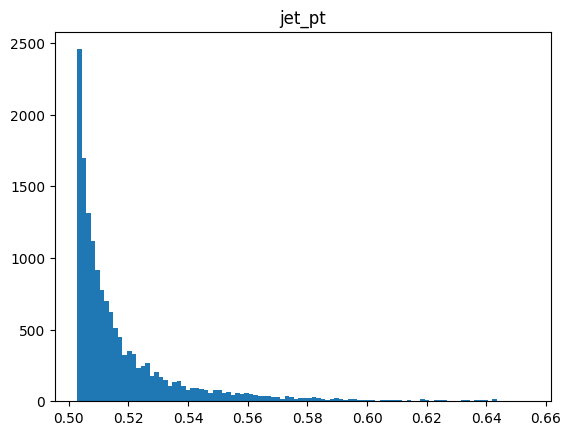

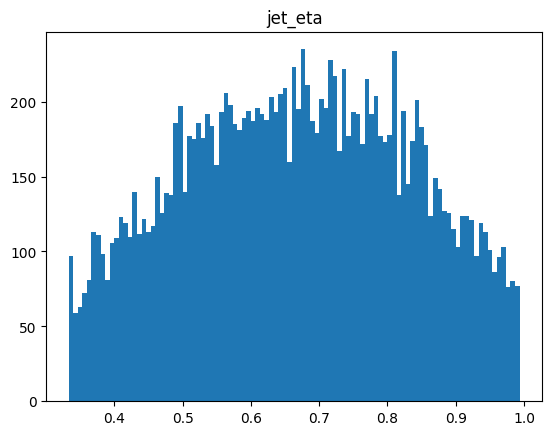

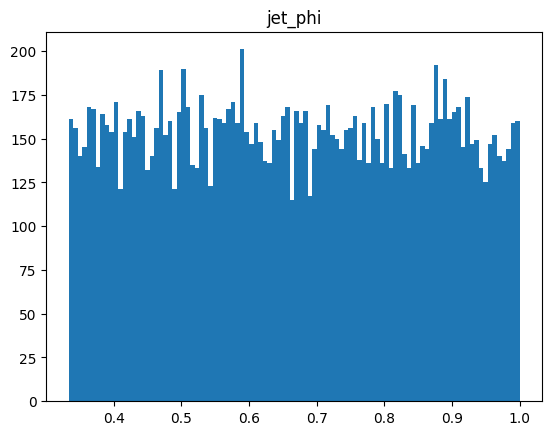

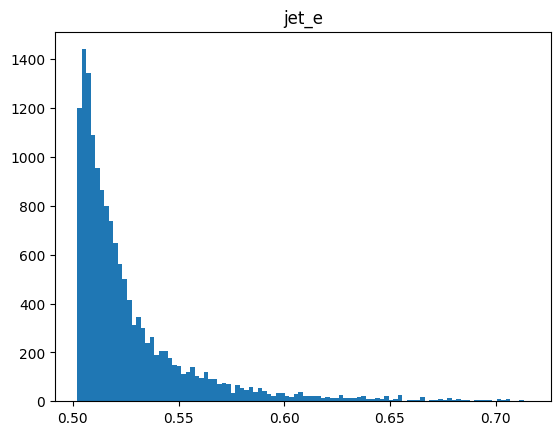

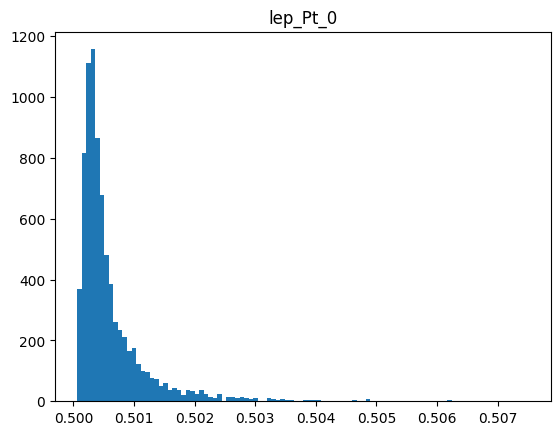

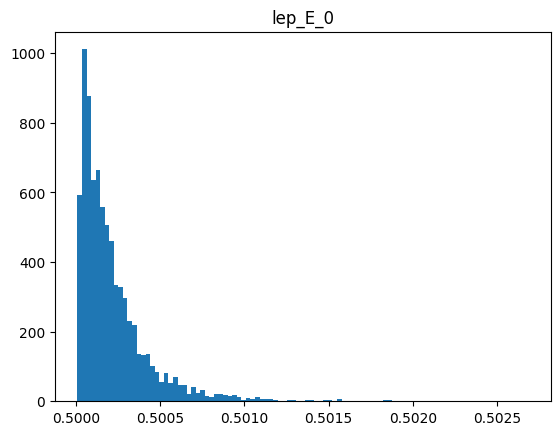

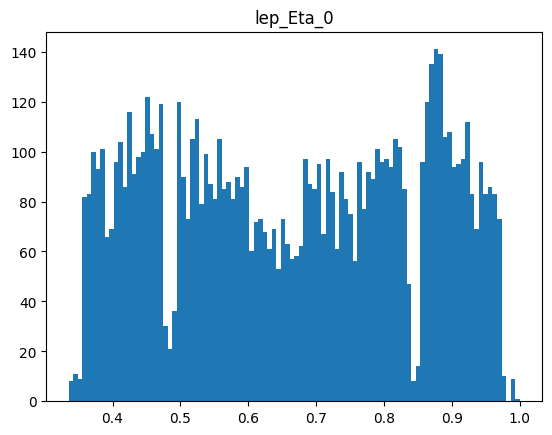

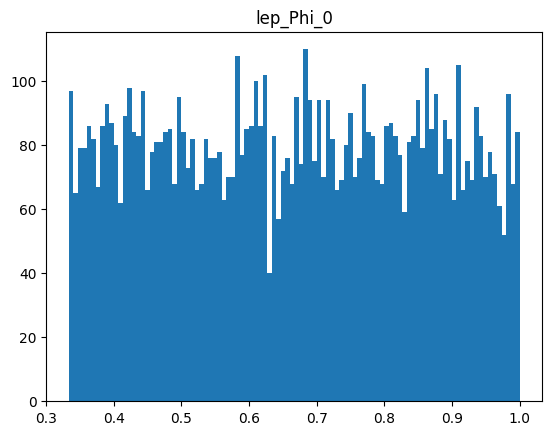

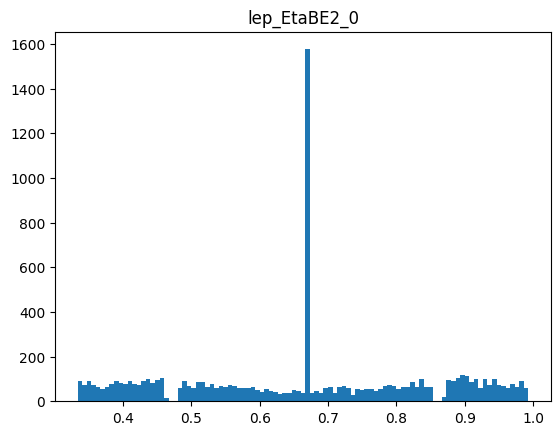

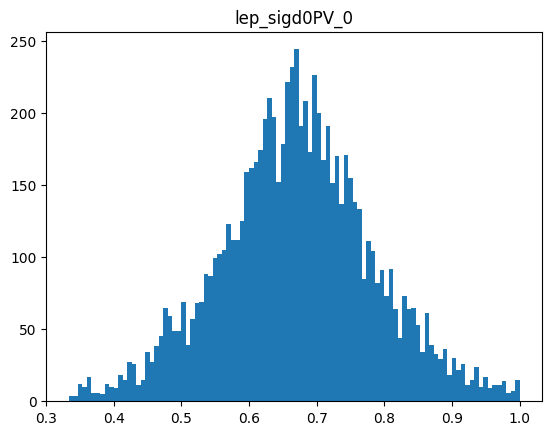

In [27]:
for i in range(0, 10):
    paint(keys[i], 100, combined_data[keys[i]])

In [27]:
globals_min

{'jet_pt': 0.5028668,
 'jet_eta': 0.33319655,
 'jet_phi': 0.33335266,
 'jet_e': 0.50213695,
 'lep_Pt_0': 0.50006557,
 'lep_E_0': 0.50000983,
 'lep_Eta_0': 0.33534834,
 'lep_Phi_0': 0.33333263,
 'lep_EtaBE2_0': 0.33326712,
 'lep_sigd0PV_0': 0.33323246,
 'lep_Z0SinTheta_0': 0.45291635,
 'lep_d0_0': 0.5930809,
 'lep_z0_0': 0.3548144,
 'lep_vz_0': 0.0,
 'lep_deltaz0_0': 0.5439439,
 'lep_RadiusCO_0': 0.22850336,
 'lep_RadiusCOX_0': 0.20439482,
 'lep_RadiusCOY_0': 0.21749033,
 'lep_SeparationMinDCT_0': 0.0009847003,
 'lep_ClosestSiTracknIL_0': 0.001994018,
 'lep_ClosestSiTrackeIL_0': 0.000999001,
 'lep_ClosestSiTracknNIL_0': 0.0029850747,
 'lep_ClosestSiTrackeNIL_0': 0.000999001,
 'lep_BestMatchTrackEta_0': 0.3333022,
 'lep_BestMatchTrackPhi_0': 0.33329377,
 'lep_BestMatchTrackD0_0': 0.6207278,
 'lep_BestMatchTrackZ0_0': 0.33962548,
 'lep_BestMatchTrackQ_0': 0.33333334,
 'lep_ClosestSiTrackEta_0': 0.0025635234,
 'lep_ClosestSiTrackD0_0': 0.02002804,
 'lep_ClosestSiTrackZ0_0': 0.102060854,
 '

In [28]:
globals_max

{'jet_pt': 0.6580691,
 'jet_eta': 1.0,
 'jet_phi': 1.0,
 'jet_e': 0.71757144,
 'lep_Pt_0': 1.0,
 'lep_E_0': 1.0,
 'lep_Eta_0': 1.0,
 'lep_Phi_0': 1.0,
 'lep_EtaBE2_0': 1.0,
 'lep_sigd0PV_0': 1.0,
 'lep_Z0SinTheta_0': 0.9339753,
 'lep_d0_0': 0.7340391,
 'lep_z0_0': 1.0,
 'lep_vz_0': 0.0,
 'lep_deltaz0_0': 0.850042,
 'lep_RadiusCO_0': 1.0,
 'lep_RadiusCOX_0': 1.0,
 'lep_RadiusCOY_0': 1.0,
 'lep_SeparationMinDCT_0': 1.0,
 'lep_ClosestSiTracknIL_0': 1.0,
 'lep_ClosestSiTrackeIL_0': 1.0,
 'lep_ClosestSiTracknNIL_0': 1.0,
 'lep_ClosestSiTrackeNIL_0': 1.0,
 'lep_BestMatchTrackEta_0': 1.0,
 'lep_BestMatchTrackPhi_0': 1.0,
 'lep_BestMatchTrackD0_0': 0.9264105,
 'lep_BestMatchTrackZ0_0': 1.0,
 'lep_BestMatchTrackQ_0': 1.0,
 'lep_ClosestSiTrackEta_0': 1.0,
 'lep_ClosestSiTrackD0_0': 1.0,
 'lep_ClosestSiTrackZ0_0': 1.0,
 'lep_ClosestSiTrackQ_0': 1.0,
 'lep_chargeIDBDTLoose_0': 1.0,
 'lep_ID_1': 1.0,
 'lep_Pt_1': 0.66921955,
 'lep_E_1': 0.69336236,
 'lep_Eta_1': 1.0,
 'lep_Phi_1': 1.0,
 'lep_EtaBE2

In [27]:
from matplotlib.backends.backend_pdf import PdfPages

In [33]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
pp = PdfPages('plots3.pdf')
for i in keys[201:]:
    fig = paint(i, 100, combined_data[i])
    plt.savefig(pp, format='pdf')
pp.close()